In [8]:

import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [9]:

DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twitter_dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
532971,0,2196959173,Tue Jun 16 13:09:18 PDT 2009,NO_QUERY,sgrcoatedpoison,bak and in pain....stood in an ants' nest ouch
971635,4,1831239161,Sun May 17 18:29:29 PDT 2009,NO_QUERY,mizd,"@martinboz Thanks, Martin! @BeatnikBetty I'm..."
866867,4,1677687247,Sat May 02 03:26:21 PDT 2009,NO_QUERY,EmzanA,what a wonderful voice he has.
884486,4,1686317606,Sun May 03 04:52:53 PDT 2009,NO_QUERY,JupiterSinclair,@mark_boardman I have heard OF them but never...
353130,0,2031853422,Thu Jun 04 10:24:49 PDT 2009,NO_QUERY,jtraver159,Im soo tried!!! and i hate stupid science sur...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


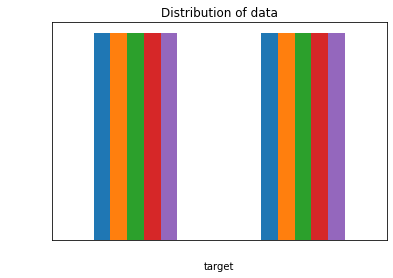

In [11]:

ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

In [12]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)

C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\628500252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [13]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [14]:
data_pos = data_pos.iloc[:int(40000)]
data_neg = data_neg.iloc[:int(40000)]
dataset = pd.concat([data_pos, data_neg])
dataset['text']=dataset['text'].str.lower()

In [15]:
dataset['text'].tail()

39995    have a quiz in spanish class tonday ..  but i ...
39996    @mittec no problems with it as such but i had ...
39997                                          ow my head 
39998    anyway... not particularly looking foreward to...
39999    allergies or insomnia? doesn't matter the reason 
Name: text, dtype: object

In [16]:
import nltk
from nltk.corpus import stopwords


In [81]:
stopwords_list = stopwords.words('english') + stopwords.words('french') + ['https','RT','@','l’','La','Le']

STOPWORDS = stopwords_list
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
#dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
#dataset['text'].head()

In [18]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

39995                quiz spanish class tonday  think pass
39996    mittec problems literally spent 2 hours cleani...
39997                                              ow head
39998    anyway particularly looking foreward labs toda...
39999                     allergies insomnia matter reason
Name: text, dtype: object

In [19]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

39995                quiz spanish class tonday  think pass
39996    mittec problems literally spent 2 hours cleani...
39997                                              ow head
39998    anyway particularly looking foreward labs toda...
39999                     allergies insomnia matter reason
Name: text, dtype: object

In [20]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

39995                quiz spanish class tonday  think pass
39996    mittec problems literally spent 2 hours cleani...
39997                                              ow head
39998    anyway particularly looking foreward labs toda...
39999                     allergies insomnia matter reason
Name: text, dtype: object

In [21]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x)) 
dataset['text'].tail()

39995                quiz spanish class tonday  think pass
39996    mittec problems literally spent  hours cleanin...
39997                                              ow head
39998    anyway particularly looking foreward labs toda...
39999                     allergies insomnia matter reason
Name: text, dtype: object

In [22]:
from nltk.tokenize import RegexpTokenizer
dataset['text'] = dataset['text'].apply(nltk.word_tokenize)


In [23]:
dataset['text'].tail()

39995          [quiz, spanish, class, tonday, think, pass]
39996    [mittec, problems, literally, spent, hours, cl...
39997                                           [ow, head]
39998    [anyway, particularly, looking, foreward, labs...
39999                [allergies, insomnia, matter, reason]
Name: text, dtype: object

In [24]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [25]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yacin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yacin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [27]:
X=data.text
y=data.target

In [28]:
X

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: object

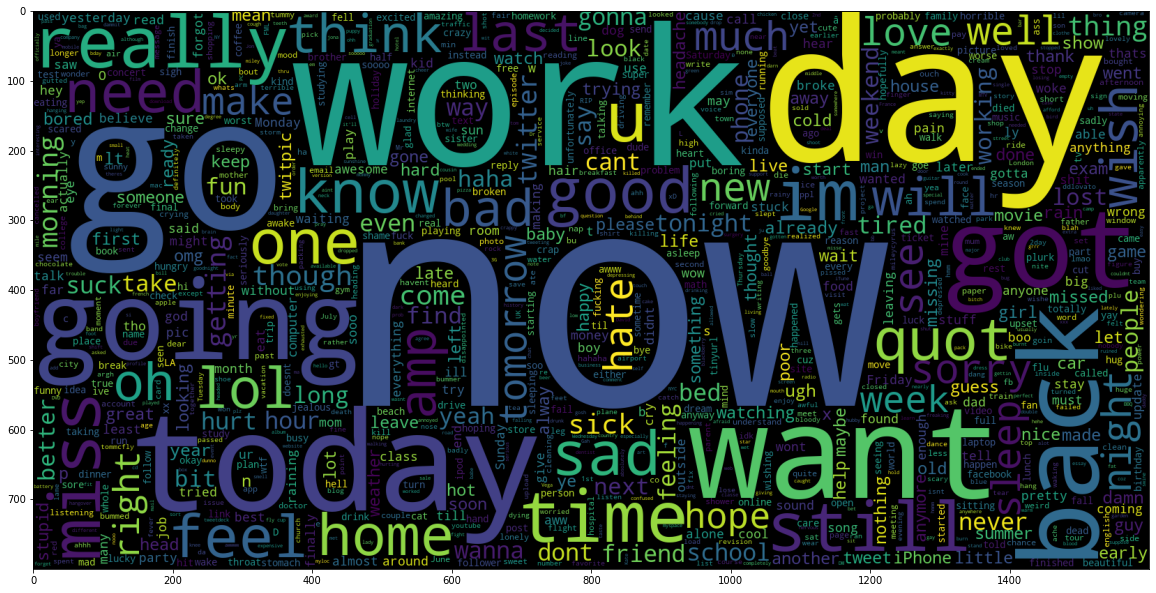

In [29]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [30]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [31]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [33]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



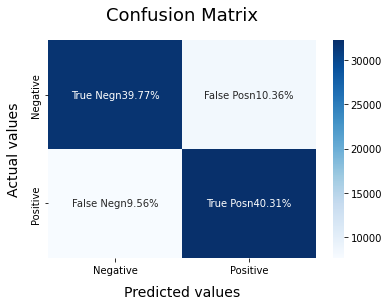

In [34]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

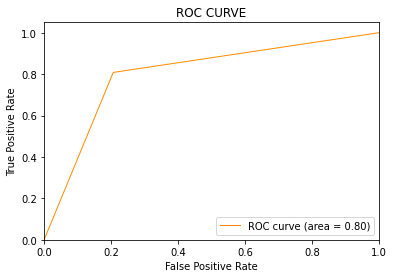

In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [82]:
test = pd.read_csv('LUTH_1.csv', delimiter=',')
test_dataset=test[['text']]

In [83]:
test_dataset

,text
0,"RT @Reinette47: Pour info @GilbertCollard, la ..."
1,RT @44muhammad_: Cheikh ’Ubayd Al-Djabiri حفظه...
2,RT @afchine_alavi: Les étudiantes et étudiants...
3,RT @TaiwanEnFrance: Très bon début aujourd’hui...
4,RT @matthletrocquer: Voilà l'état de la jeunes...
...,...
62064,RT @EricNaulleau: Rappel : Alexis Corbière a j...
62065,"j’ai faillis intégrer cette université xptdr, ..."
62066,@StavrosPapaioa2 @dioko_emmany En plus il se d...
62067,« Nous avons le plus grand respect pour l’indi...


In [84]:
test_dataset['text'] = test_dataset['text'].apply(lambda text: cleaning_stopwords(text))
test_dataset['text'].head()

C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\1702472668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text'] = test_dataset['text'].apply(lambda text: cleaning_stopwords(text))


0    @Reinette47: Pour info @GilbertCollard, tueuse...
1    @44muhammad_: Cheikh ’Ubayd Al-Djabiri حفظه ال...
2    @afchine_alavi: Les étudiantes étudiants l'uni...
3    @TaiwanEnFrance: Très bon début aujourd’hui Jo...
4    @matthletrocquer: Voilà l'état jeunesse @Emman...
Name: text, dtype: object

In [85]:
test_dataset['text']= test_dataset['text'].apply(lambda x: cleaning_punctuations(x))

test_dataset['text'] = test_dataset['text'].apply(lambda x: cleaning_repeating_char(x))

test_dataset['text'] = test_dataset['text'].apply(lambda x: cleaning_URLs(x))

test_dataset['text'] = test_dataset['text'].apply(lambda x: cleaning_numbers(x)) 

test_dataset['text'].head()

C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\4153916872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text']= test_dataset['text'].apply(lambda x: cleaning_punctuations(x))
C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\4153916872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text'] = test_dataset['text'].apply(lambda x: cleaning_repeating_char(x))
C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\4153916872.py:5: SettingWithCopyWarning: 
A value is trying to 

0    Reinette Pour info GilbertCollard tueuse barba...
1    muhammad Cheikh ’Ubayd AlDjabiri حفظه الله dit...
2    afchinealavi Les étudiantes étudiants lunivers...
3    TaiwanEnFrance Très bon début aujourd’hui Jour...
4    matthletrocquer Voilà létat jeunesse EmmanuelM...
Name: text, dtype: object

In [86]:
# Remove all the special characters
def rm_special_char(text):
    return re.sub(r'\W', '', text)  

def rm_all_single_char(text):
    return re.sub(r'\s+[a-zA-Z]\s+', '', text)

def rm_single_start_char(text):
    return re.sub(r'\^[a-zA-Z]\s+', '', text)

In [87]:
#test_dataset['text'] = test_dataset['text'].apply(lambda x: rm_special_char(x)) 
test_dataset['text'] = test_dataset['text'].apply(lambda x: rm_all_single_char(x)) 
test_dataset['text'] = test_dataset['text'].apply(lambda x: rm_single_start_char(x)) 

C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\2555470470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text'] = test_dataset['text'].apply(lambda x: rm_all_single_char(x))
C:\Users\yacin\AppData\Local\Temp\ipykernel_16156\2555470470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text'] = test_dataset['text'].apply(lambda x: rm_single_start_char(x))


In [88]:
test_dataset['text'].tail()

62064    EricNaulleau Rappel  Alexis Corbière jugé Samu...
62065    j’ai faillis intégrer cette université xptdr j...
62066    StavrosPapaioa diokoemmany En plus dit médecin...
62067    « Nous plus grand respect l’individu SamuelPat...
62068    JRVinciguerra sarahelhairy Nul doit être inqui...
Name: text, dtype: object

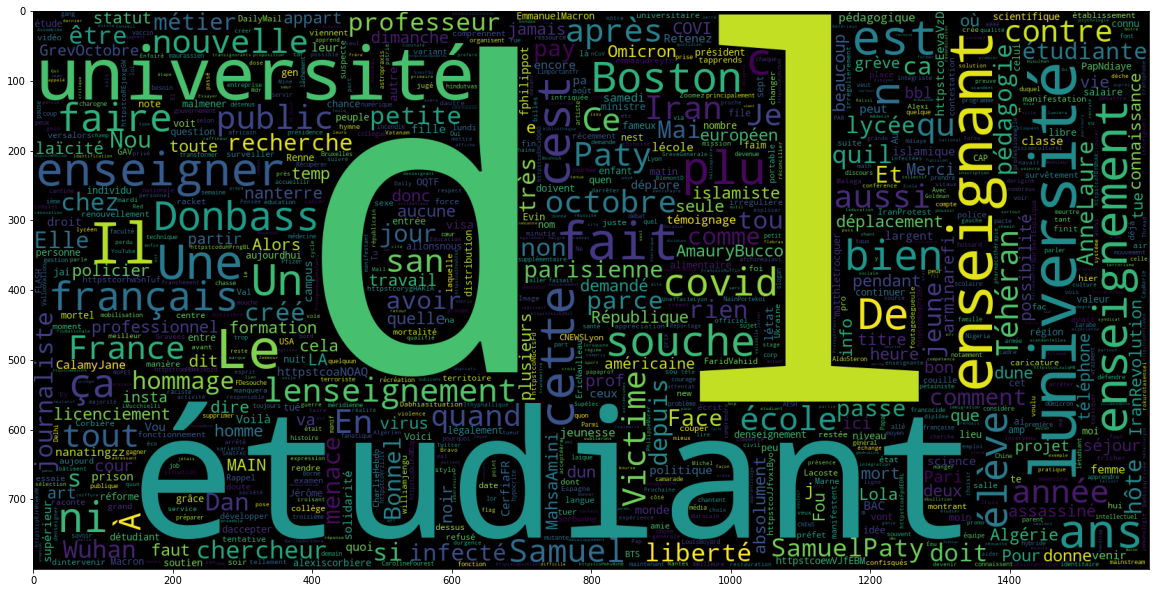

In [89]:
data_tewe = test_dataset['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_tewe))
plt.imshow(wc)

In [ ]:
#test_dataset['text'] = test_dataset['text'].apply(nltk.word_tokenize)

test_dataset['text']= test_dataset['text'].apply(lambda x: stemming_on_text(x))

test_dataset['text'] = test_dataset['text'].apply(lambda x: lemmatizer_on_text(x))
test_dataset['text'].head()

C:\Users\yacin\AppData\Local\Temp\ipykernel_23032\96761159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text']= test_dataset['text'].apply(lambda x: stemming_on_text(x))
C:\Users\yacin\AppData\Local\Temp\ipykernel_23032\96761159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['text'] = test_dataset['text'].apply(lambda x: lemmatizer_on_text(x))


0    Reinette Pour info GilbertCollard tueuse barba...
1    muhammad Cheikh ’Ubayd AlDjabiri حفظه الله dit...
2    afchinealavi Les étudiantes étudiants lunivers...
3    TaiwanEnFrance Très bon début aujourd’hui Jour...
4    matthletrocquer Voilà létat jeunesse EmmanuelM...
Name: text, dtype: object

In [ ]:
X_test1  = vectoriser.transform(test_dataset['text'])

In [ ]:
y_pred1 = BNBmodel.predict(X_test1)

In [ ]:
y_pred1

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
test_dataset['prob'] = BNBmodel.predict(X_test1)

C:\Users\yacin\AppData\Local\Temp\ipykernel_23032\63349428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['prob'] = BNBmodel.predict(X_test1)


In [ ]:
test_dataset.tail()

,text,prob
62064,EricNaulleau Rappel Alexis Corbière jugé Samu...,1
62065,j’ai faillis intégrer cette université xptdr j...,1
62066,StavrosPapaioa diokoemmany En plus dit médecin...,1
62067,« Nous plus grand respect l’individu SamuelPat...,1
62068,JRVinciguerra sarahelhairy Nul doit être inqui...,1
